This file takes in cropped satellite image of a city and produces images chips and saves them as numpy arrays. I've used Sentinale image with a resolution of 10 meters.

The bands of the images are - blue, green, red, nir, ndvi, landcover (from ESA landcover), ndbi, ndwi

The output chips have only 3 bands, and are filtered - only chips that have more then a thershold of 10% of parks are saved to have a bit more balanced dataset.

In [ ]:
#install packages
!pip install pyrsgis
!pip install rasterio
!pip install patchify

In [2]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import rasterio
import numpy as np
from osgeo import gdal

In [4]:
def image_file_to_array(city):  
  '''  read the satellite image file   '''
 
  image_file_path = os.path.join(dir, city, image_file_name)
  image = gdal.Open(image_file_path)
  image_array = image.ReadAsArray()
  image_array = np.transpose(image_array, [1, 2, 0])  # transpose the first and third axis

  return image_array


def park_file_to_array(city):

  '''  read the satellite image file   '''

  park_file_path = os.path.join(dir, city, park_file_name)
  park = gdal.Open(park_file_path)
  park_array = park.ReadAsArray()
  park_array = np.expand_dims(park_array, axis = 2) # expand from 2D to 3D
  park_array[park_array > 1] = 1                    # repalce values greater than 1 with 1

  return park_array

In [5]:
import os
import rasterio
import numpy as np
from osgeo import gdal

# set the directory and file 
dir = #location of main folder
image_file_name = 'image_bgr_nir_ndvi_landcover_ndbi_ndwi.tif'
park_file_name = 'parks.tif'

city = "Seattle"

image_array = image_file_to_array(city)
park_array = park_file_to_array(city)

In [6]:
print(image_array.shape)
print(park_array.shape)

(2660, 1465, 8)
(2660, 1465, 1)


In [7]:
#check for null values
print(np.unique(np.isnan(image_array)))
print(np.unique(np.isnan(park_array)))

[False]
[False]


Leave only 3 bands - blue, green, red

In [8]:
image_array = image_array[:,:,[0,1,2]]

In [9]:
print(image_array.shape)
print(park_array.shape)

(2660, 1465, 3)
(2660, 1465, 1)


patchify to create image and mask patches

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [11]:
# define functions to crop images and corresponding masks into proper size

def create_image_chips(image_file, patch_size, step):
  '''
  This function creates chips for satellite image
  Input  - image_file: np.array of satellite image
         - patch_size: size of output chips, e.g. 256 or 128
         - step: stride for cropping (when smaller then stride you get overlapping chips)
  Output - np.array for chips of satellite image
  '''
 
  scaler = MinMaxScaler() # scale to the min = 0, and max = 1
  
  image_dataset = []
  patches_img = patchify(image_file, (patch_size, patch_size, image_file.shape[2]), step=step)  
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]   
      # scale to min = 0, max = 1          
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
      image_dataset.append(single_patch_img) 
  image_dataset = np.array(image_dataset)

  return image_dataset

def create_mask_chips(park_file, patch_size, step):
  '''
  This function creates chips for park images (rasterized park dataset)
  Input  - park_file: np.array of satellite image
         - patch_size: size of output chips, e.g. 256 or 128
         - step: stride for cropping (when smaller then stride you get overlapping chips) ! patch and stride should be the same for mask and for images
  Output - np.array for chips of mask
  '''
  scaler = MinMaxScaler() # scale to the min = 0, and max = 1
  park_dataset = []
  patches_img = patchify(park_file, (patch_size, patch_size, 1), step=step)  
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):      
      single_patch_img = patches_img[i,j,:,:]
      # scale to min = 0, max = 1 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
      park_dataset.append(single_patch_img)
  park_dataset = np.array(park_dataset)

  return park_dataset

In [12]:
#create patches
patch_size=256
step=20
image_dataset = create_image_chips(image_array, patch_size=patch_size, step=step)
park_dataset = create_mask_chips(park_array, patch_size=patch_size, step=step)

In [13]:
#check the datasets
print(image_dataset.shape)
print(park_dataset.shape)
print(image_dataset.max())
print(image_dataset.min())
print(image_dataset[:,:,:,0].max())
print(image_dataset[:,:,:,0].min())
print(image_dataset[:,:,:,1].max())
print(image_dataset[:,:,:,1].min())
print(image_dataset[:,:,:,2].max())
print(image_dataset[:,:,:,2].min())
print(np.unique(park_dataset))

(7381, 256, 256, 3)
(7381, 256, 256, 1)
1.0000002
0.0
1.0000002
0.0
1.0000002
0.0
1.0000001
0.0
[0. 1.]


In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


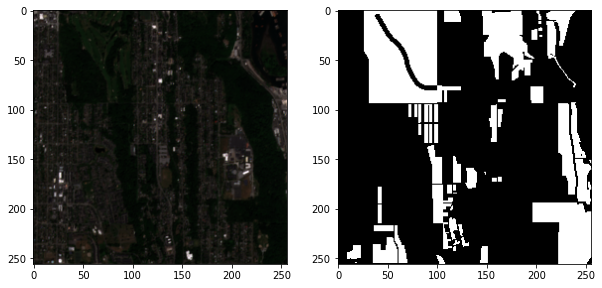

In [15]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

plt.subplot(121)
img_r = image_dataset[image_number,:,:,2]
img_g = image_dataset[image_number,:,:,1]
img_b = image_dataset[image_number,:,:,0]
img_nir_col = np.dstack((img_r, img_g, img_b))
plt.imshow(img_nir_col)

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

Delete chips that have less then 10% of public urban green spaces

In [16]:
chips_10_pugs = []
for i in range(len(park_dataset)):
  one_chip = park_dataset[i, :, :, 0]
  one_chip = one_chip.flatten()
  pixel_n = len(one_chip)
  park_pixel = sum(one_chip == 1)
  #print(park)
  if park_pixel >= 0.1*pixel_n:
    chips_10_pugs.append(i)

In [17]:
len(chips_10_pugs)

1826

In [18]:
image_dataset_balanced = []
pugs_dataset_balanced = []
for i in range(len(image_dataset)):
  if i in chips_10_pugs:
    image_copy = image_dataset[i]
    park_copy = park_dataset[i]
    image_dataset_balanced.append(image_copy)
    pugs_dataset_balanced.append(park_copy)
image_dataset_balanced = np.array(image_dataset_balanced)
pugs_dataset_balanced = np.array(pugs_dataset_balanced)
print(image_dataset_balanced.shape)
print(pugs_dataset_balanced.shape)

(1826, 256, 256, 3)
(1826, 256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


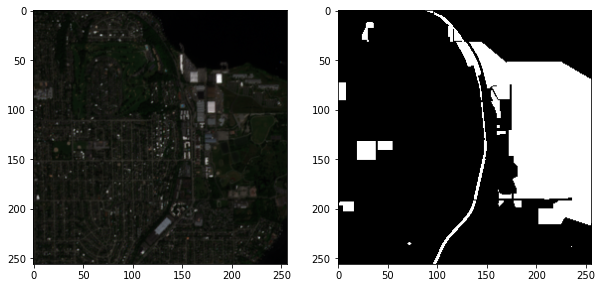

In [22]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset_balanced)-1)
plt.figure(figsize=(10, 5))

plt.subplot(121)
img_r = image_dataset_balanced[image_number,:,:,2]
img_g = image_dataset_balanced[image_number,:,:,1]
img_b = image_dataset_balanced[image_number,:,:,0]
img_nir_col = np.dstack((img_r, img_g, img_b))
plt.imshow(img_nir_col)

# plot parks
plt.subplot(122)
plt.imshow(pugs_dataset_balanced[image_number,:,:,0], cmap='gray')
plt.show()


Save to numpy arrays

In [20]:
#save image at city folder in specific folder for chips
folder = "1_chips_10_b_g_r"
file_name = "image_chips_balanced.npy"
save_dir = os.path.join(dir, city, folder, file_name)
np.save(save_dir, image_dataset_balanced)


In [21]:
#save masks
file_name_pugs = "pugs_chips_balanced.npy"
save_dir = os.path.join(dir, city, folder, file_name_pugs)
np.save(save_dir, pugs_dataset_balanced)